El Sistema Nacional de Información sobre Biodiversidad de México (SNIB) es una 
base de datos con registro de ocurrencias biológicas que ha recopilado la 
Comisión Nacional para el Uso y Conocimiento de la Biodiversidad (CONABIO) 
desde su creación. Esta colección integra gran parte de las colecciones 
biológicas de México. 

Hay dos maneras principales de accesar a la información contenida en el SNIB,
la primera es descargando los datos desde el [Geoportal] de CONABIO y la 
segunda desde el la página del [SNIB](http://www.snib.mx/). Un buen consejo 
es siempre usar el método de descarga desde el sitio del [Geoportal], estos 
los encontramos en Biodiversidad → Ejemplares y ahí escogemos el *grupo* 
biológico en el que estemos interesados en este *post* usaremos los registros 
de [mamíferos](http://www.snib.mx/ejemplares/mamiferos.201807.csv.zip) y el 
mapa de [áreas naturales protegidas de 
México](http://www.conabio.gob.mx/informacion/gis/maps/geo/anpmx.zip) el cual 
también descargamos del [Geoportal].

[Geoportal]: http://geoportal.conabio.gob.mx/

In [1]:
library(magrittr)

In [2]:
MAMMALS_URI <- 'http://www.snib.mx/ejemplares/mamiferos.201807.csv.zip'
ANPS_MX_URI <- 'http://www.conabio.gob.mx/informacion/gis/maps/geo/anpmx.zip'

mammals_zip <- tempfile(fileext = '.zip')
anps_zip <- tempfile(fileext = '.zip')

curl::curl_download(MAMMALS_URI, mammals_zip)
curl::curl_download(ANPS_MX_URI, anps_zip)

En el archivo zip de mamíferos se tienen los siguientes archivos:

In [3]:
mammals_zip %>% 
    unzip(list = TRUE)

Name,Length,Date
<chr>,<dbl>,<dttm>
mamiferos.csv,769181127,2018-07-25 14:59:00
mamiferos.html,412294,2018-07-26 16:46:00
mamiferos.png,325960,2018-07-26 15:26:00
mamiferos.xml,221369,2018-07-26 14:11:00
mamiferosca.csv,745501,2018-07-25 16:23:00
mamiferoseua.csv,6609036,2018-07-25 16:25:00
mamiferoslicencia.csv,85796,2018-07-26 09:26:00
mamiferosutm11.csv,36854955,2018-07-25 15:24:00
mamiferosutm12.csv,85395267,2018-07-25 15:29:00


Los archivos `.html` y `.xml` corresponden a archivos de metadatos. Los 
archivos `mamiferosutm*.csv` son lo archivos de registros correspondientes 
a las regiones UTM nombradas. Mientras que `mamiferosca.csv` y 
`mamiferoseua.csv` corresponden a registros en Centroamérica y Estados 
Unidos de América. El archivo que `mamiferoslicencia.csv` contiene la 
licencia de uso de cada datos según el proyecto asociado. Y el archivo
que usaremos es el `mamiferos.csv` el cual es el concentrado de todos
los registros, aunque muchas veces es demasiado grande para ser trabajado
en un computadora (depende de la cantidad de memoria RAM de tu equipo).

En todo momento usaremos las bibliotecas: `dplyr`, `readr`, `sf`, `maps`, 
`ggplot2` y `magrittr`. 

In [4]:
library(dplyr)
library(readr)
library(sf)
library(ggplot2)
library(maps)
library(maptools)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.8.0, GDAL 3.0.2, PROJ 6.2.1

Loading required package: sp

Checking rgeos availability: TRUE



Para leer el archivo usaremos `read_csv`, en lugar de el comando base de
`R` ya que es más confiable.

In [5]:
mammals_data <- mammals_zip %>% 
    unzip(files = c('mamiferos.csv'), exdir = tempdir()) %>% 
    read_csv()

mammals_data %<>% select(idejemplar,
                        reinovalido,
                        phylumdivisionvalido,
                        clasevalida,
                        ordenvalido,
                        familiavalida,
                        generovalido,
                        especievalida,
                        diacolecta,
                        mescolecta,
                        aniocolecta,
                        probablelocnodecampo,
                        longitud,
                        latitud, 
                        estadomapa) %>%
  st_as_sf(coords = c("longitud", "latitud"),
           crs = 4326)

mammals_data %>% head()

Parsed with column specification:
cols(
  .default = col_character(),
  longitud = col_double(),
  latitud = col_double(),
  categoriaresidenciaaves = col_logical(),
  formadecrecimiento = col_logical(),
  taxonextinto = col_logical(),
  ultimafechaactualizacion = col_date(format = ""),
  categoriainfraespecie2 = col_logical(),
  categoriainfraespecie2valida = col_logical(),
  mt24claveestadomapa = col_logical(),
  mt24nombreestadomapa = col_logical(),
  mt24clavemunicipiomapa = col_logical(),
  mt24nombremunicipiomapa = col_logical(),
  altitudmapa = col_double(),
  fechadeterminacion = col_logical(),
  diadeterminacion = col_double(),
  mesdeterminacion = col_double(),
  aniodeterminacion = col_double(),
  diacolecta = col_double(),
  mescolecta = col_double(),
  aniocolecta = col_double()
  # ... with 2 more columns
)

See spec(...) for full column specifications.

Warning message:
“425069 parsing failures.
 row                 col           expected actual                          

idejemplar,reinovalido,phylumdivisionvalido,clasevalida,ordenvalido,familiavalida,generovalido,especievalida,diacolecta,mescolecta,aniocolecta,probablelocnodecampo,estadomapa,geometry
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<POINT [°]>
47289ba599f987513bae537cf5f4bda8,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Artibeus,Artibeus lituratus,19,10,1999,NA,CHIAPAS,POINT (-93.81914 15.94414)
bd94ea2dd0ea46e05376aea743cb55eb,Animalia,Chordata,Mammalia,Chiroptera,Phyllostomidae,Artibeus,Artibeus lituratus,19,10,1999,NA,CHIAPAS,POINT (-93.81914 15.94414)
f363a73c42a16767df054de7fa165d6e,Animalia,Chordata,Mammalia,Rodentia,Heteromyidae,Heteromys,Heteromys salvini crispus,20,10,1999,NA,CHIAPAS,POINT (-93.81914 15.94414)
3d279e1f803665450a43ff32a7a7701a,Animalia,Chordata,Mammalia,Primates,Atelidae,Ateles,Ateles geoffroyi vellerosus,19,5,1989,NA,CHIAPAS,POINT (-91.11667 16.71944)
4505a17f94f13b01676da0c877dee92b,NA,NA,NA,NA,NA,NA,NA,22,2,1999,NA,CHIAPAS,POINT (-92.80556 15.65528)
dfe4724c85b3304fcac2d033866447c6,Animalia,Chordata,Mammalia,Rodentia,Cricetidae,Peromyscus,Peromyscus guatemalensis guatemalensis,22,2,1999,NA,CHIAPAS,POINT (-92.80556 15.65528)


Lo que hemos conseguido al hacer esta lectura es tener un `data.frame` con una
columna especial que tiene la geometría del registro, en este caso el punto 
asociado a la ocurrencia de un taxón, ahora bien no hemos considerado todas las
columnas de los registros si no solo algunas (para una explicación de que dato
viene en cada columna se puede consultar el 
[_Diccionario de datos de Ejemplares Geoportal_](http://www.snib.mx/documents/docsnib.html)
). 

Ahora podemos resolver preguntas básicas a los datos como, cual es la 
representación de las familias del orden _Rodentia_ en lo datos.

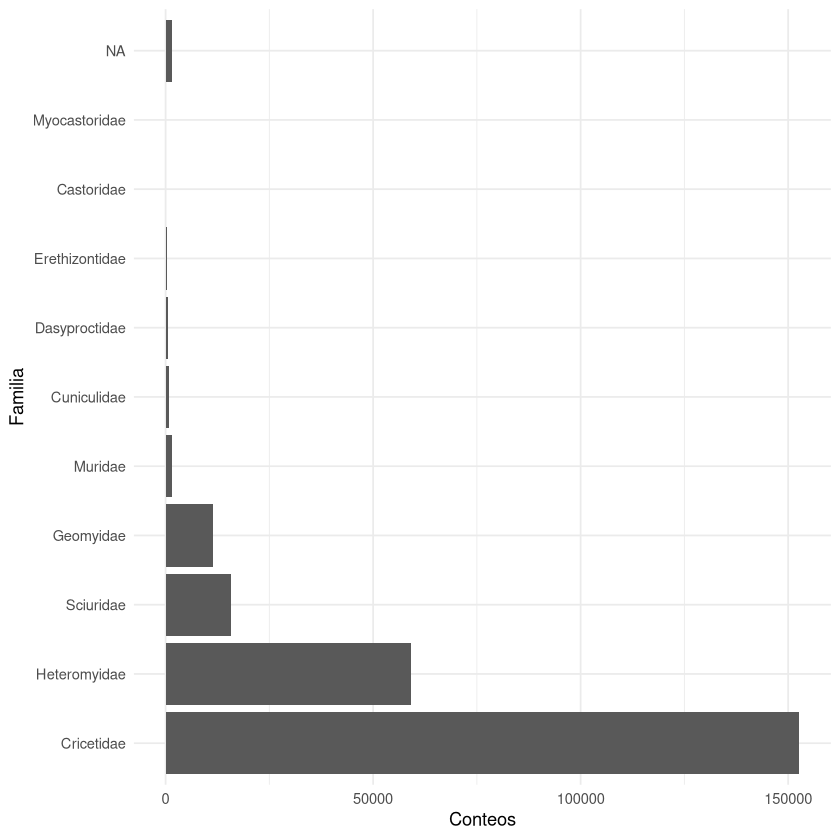

In [6]:
mammals_data %>% 
    filter(ordenvalido == "Rodentia") %>%
    ggplot() + 
        geom_bar(mapping = aes(x = forcats::fct_infreq(familiavalida))) +
        coord_flip() + 
        theme_minimal() +
        labs(x = "Familia", y = "Conteos")

En general podríamos trabajar muchas más preguntas de este estilo pero gracias
a que  agregamos la geometría asociada a los datos también podemos ocuparla 
para hacer cosas más interesantes. 

Reading layer `anpmx' from data source `/tmp/Rtmpq0hQKv/anpmx.shp' using driver `ESRI Shapefile'
Simple feature collection with 182 features and 19 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -118.6344 ymin: 11.9686 xmax: -85.39723 ymax: 32.48333
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


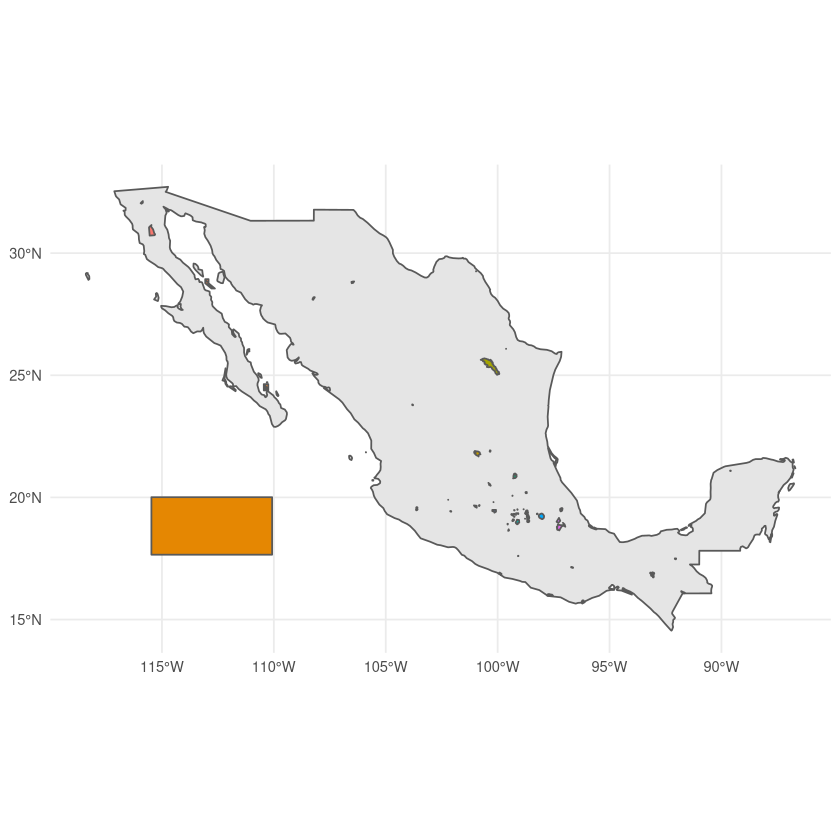

In [7]:
mx_border <- st_as_sf(maps::map('world', 
                                regions = "Mexico", 
                                plot = FALSE, 
                                fill = TRUE))

anps_zip %>% 
    unzip(exdir = tempdir())

mx_national_parks <- file.path(tempdir(), 'anpmx.shp') %>%
    st_read() %>%
    select(ID_ANP,
           NOMBRE, 
           CAT_DECRET,
           REGION) %>%
    filter(CAT_DECRET == "PN")

ggplot() +
    geom_sf(data = mx_border) +
    geom_sf(data = mx_national_parks, 
            aes(fill = ID_ANP), 
            show.legend = FALSE) + 
    theme_minimal()

Vamos a restringir nuestra atención al parque nacional 
_Cumbres del Ajusco_. Este parque nacional se encuentra en la CDMX
y en particular existe un conejo endemico el _Teporingo_. Vamos a explorar
los registro de mamíferos del este parque nacional que existan en los datos
del SNIB. 

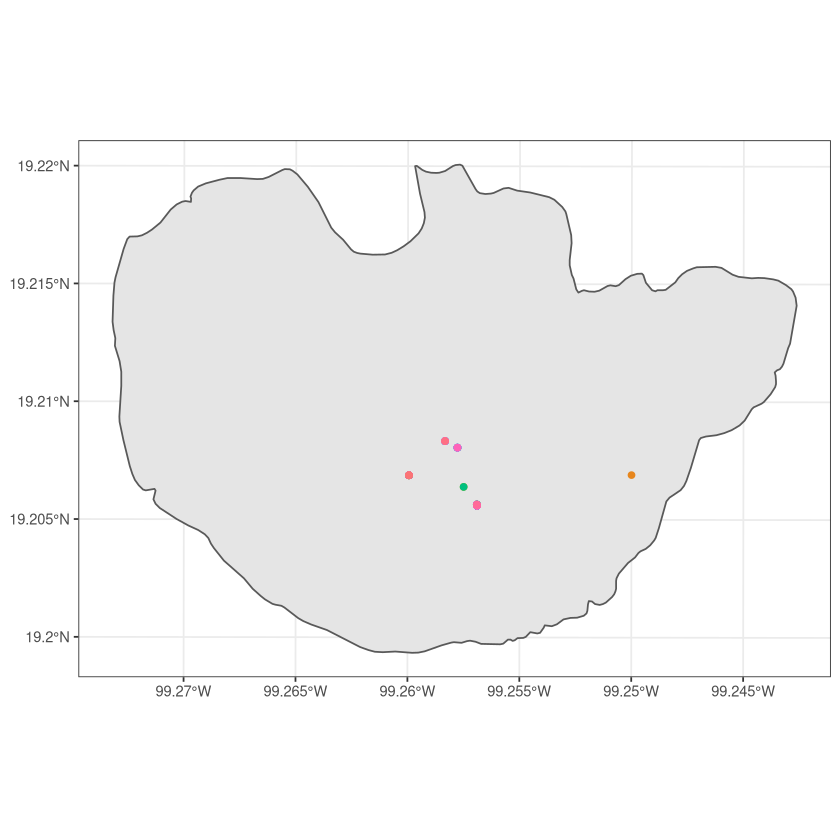

In [8]:
ajusco_national_park <- mx_national_parks %>%
    filter(NOMBRE == "Cumbres del Ajusco") %>%
    st_geometry() %>%
    st_transform(crs = 6369)

mammals_data <- mammals_data %>%
    st_transform(crs = 6369)

snib_data_ajusco <- mammals_data %>%
    filter(lengths(st_within(., ajusco_national_park)) > 0)

ggplot() +
    geom_sf(data = ajusco_national_park) +
    geom_sf(data = snib_data_ajusco, aes(colour = idejemplar), show.legend = FALSE) +
    theme_bw()

Además tenemos los siguientes órdenes representados,

In [9]:
snib_data_ajusco %>% 
    st_set_geometry(NULL) %>%
    group_by(ordenvalido) %>% 
    count()

ordenvalido,n
<chr>,<int>
Carnivora,1
Chiroptera,2
Cingulata,1
Lagomorpha,13
Rodentia,97
Soricomorpha,3


En particular en los registros de _Lagomorpha_ se tiene el _Romerolagus diazi_ o teporingo.

In [10]:
snib_data_ajusco %>% 
    st_set_geometry(NULL) %>% 
    filter(ordenvalido == 'Lagomorpha') %>%
    group_by(especievalida) %>% 
    count()

especievalida,n
<chr>,<int>
Romerolagus diazi,2
Sylvilagus cunicularius,4
Sylvilagus cunicularius cunicularius,7


In [11]:
snib_data_ajusco %>%  
  st_transform(crs = 4326) %>%
  filter(especievalida == "Romerolagus diazi") %>%
  select(idejemplar, ordenvalido, especievalida)

,idejemplar,ordenvalido,especievalida,geometry
,<chr>,<chr>,<chr>,<POINT [°]>
1,977c83f6aa37099818e7099bd2dc9f5d,Lagomorpha,Romerolagus diazi,POINT (-99.25833 19.20833)
2,ee8d6d14edcec9bb64441c44d8a67467,Lagomorpha,Romerolagus diazi,POINT (-99.25691 19.20564)


In [12]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libopenblasp-r0.3.7.so
LAPACK: /usr/lib/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] maptools_0.9-9 sp_1.3-1       maps_3.3.0     ggplot2_3.2.1  sf_0.8-0      
[6] readr_1.3.1    dplyr_0.8.3    magrittr_1.5  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1         pillar_1.4.2       compiler_3.6.2     forcats_0.4.0     
 [5] base64enc_0.1-3    class_7.3-15       tools_3.6.2        z